# Capstone - 3 Preprocessing  & Modeling : Improving NYC's Services To 311 Requests

Following the data wrangling and exploratory analysis phases, this stage focuses on preparing the dataset for predictive modeling to better understand patterns in NYC’s 311 service response times. Preprocessing involves transforming categorical variables into machine readable formats using one hot encoding, standardizing feature scales, and splitting the dataset into training and testing subsets to ensure valid model evaluation.

To support data driven decision making, the project introduces a binary classification task: predicting whether a 311 complaint will receive a slow response, defined as taking more than three days to close. This modeling approach helps identify which types of complaints, boroughs, or agencies are more likely to experience delays. By learning from past response behaviors, the model aims to surface early warning signals that can be used by city agencies to improve operational efficiency and equity in service delivery.


## Load the Libraries and the Data

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [115]:
service_requests = pd.read_csv("cleaned_311_2016_subset.csv")

## Check the Data

In [118]:
service_requests.head()

,Created Date,Closed Date,Agency,Complaint Type,Descriptor,Incident Zip,Borough,Latitude,Longitude,Status,Response Time (Hours),Is Closed
0,2016-09-30 00:00:00,2016-10-03 00:00:01,DOHMH,Food Poisoning,1 or 2,10029.0,Manhattan,40.789715,-73.946040,Closed,72.000278,True
1,2016-09-30 00:00:00,2016-10-06 00:00:00,HPD,Heat/Hot Water,ENTIRE BUILDING,11203.0,Brooklyn,40.652807,-73.931519,Closed,144.000000,True
2,2016-09-30 00:00:00,2016-09-30 00:00:00,DOHMH,Rodent,Mouse Sighting,10028.0,Manhattan,40.778587,-73.955567,Closed,0.000000,True
3,2016-09-30 00:00:00,2016-10-12 00:00:00,DOHMH,Rodent,Rat Sighting,11377.0,Queens,40.745769,-73.907326,Closed,288.000000,True
4,2016-09-30 00:00:00,2016-10-11 00:00:00,DOHMH,Standing Water,Container - Over 5 Gallons,11435.0,Queens,40.690316,-73.799074,Closed,264.000000,True


In [120]:
service_requests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139007 entries, 0 to 139006
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Created Date           139007 non-null  object 
 1   Closed Date            135850 non-null  object 
 2   Agency                 139007 non-null  object 
 3   Complaint Type         139007 non-null  object 
 4   Descriptor             132861 non-null  object 
 5   Incident Zip           134306 non-null  float64
 6   Borough                139007 non-null  object 
 7   Latitude               128524 non-null  float64
 8   Longitude              128524 non-null  float64
 9   Status                 139007 non-null  object 
 10  Response Time (Hours)  135850 non-null  float64
 11  Is Closed              139007 non-null  bool   
dtypes: bool(1), float64(4), object(7)
memory usage: 11.8+ MB


In [122]:
service_requests.shape

(139007, 12)

In [124]:
# check for missing values
service_requests.isnull().sum()

Created Date                 0
Closed Date               3157
Agency                       0
Complaint Type               0
Descriptor                6146
Incident Zip              4701
Borough                      0
Latitude                 10483
Longitude                10483
Status                       0
Response Time (Hours)     3157
Is Closed                    0
dtype: int64

In [126]:
# Drop rows with missing response time
service_requests = service_requests[service_requests['Response Time (Hours)'].notnull()]

In [128]:
# Drop rows without lat/long
service_requests = service_requests[service_requests['Latitude'].notnull() & service_requests['Longitude'].notnull()]

In [130]:
# Re format the zipcode
service_requests['Incident Zip'] = service_requests['Incident Zip'].astype(str).str.split('.').str[0]

In [132]:
#Confirm that ' Status'  and 'Is Closed' are always aligned
service_requests[['Status', 'Is Closed']].value_counts()

Status            Is Closed
Closed            True         124777
Pending           True            670
Assigned          True             12
Closed - Testing  True              9
Open              True              1
Started           True              1
Name: count, dtype: int64

<Axes: >

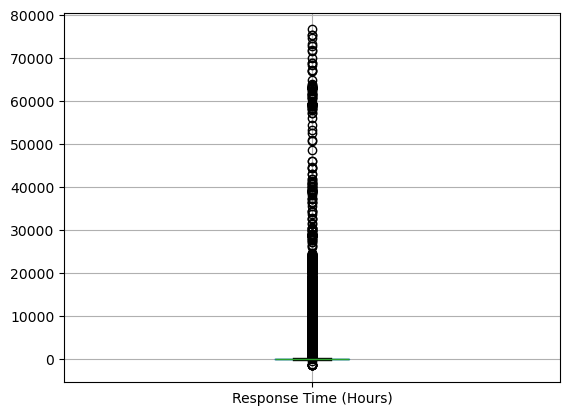

In [134]:
#Check for Outliers
service_requests['Response Time (Hours)'].describe()
service_requests.boxplot(column='Response Time (Hours)')

In [136]:
service_requests.head()

,Created Date,Closed Date,Agency,Complaint Type,Descriptor,Incident Zip,Borough,Latitude,Longitude,Status,Response Time (Hours),Is Closed
0,2016-09-30 00:00:00,2016-10-03 00:00:01,DOHMH,Food Poisoning,1 or 2,10029,Manhattan,40.789715,-73.946040,Closed,72.000278,True
1,2016-09-30 00:00:00,2016-10-06 00:00:00,HPD,Heat/Hot Water,ENTIRE BUILDING,11203,Brooklyn,40.652807,-73.931519,Closed,144.000000,True
2,2016-09-30 00:00:00,2016-09-30 00:00:00,DOHMH,Rodent,Mouse Sighting,10028,Manhattan,40.778587,-73.955567,Closed,0.000000,True
3,2016-09-30 00:00:00,2016-10-12 00:00:00,DOHMH,Rodent,Rat Sighting,11377,Queens,40.745769,-73.907326,Closed,288.000000,True
4,2016-09-30 00:00:00,2016-10-11 00:00:00,DOHMH,Standing Water,Container - Over 5 Gallons,11435,Queens,40.690316,-73.799074,Closed,264.000000,True


## Feature Engineering

In [139]:
# Create response time (in days)
service_requests['Created Date'] = pd.to_datetime(service_requests['Created Date'])
service_requests['Closed Date'] = pd.to_datetime(service_requests['Closed Date'])
service_requests['Response Time'] = (service_requests['Closed Date'] - service_requests['Created Date']).dt.days

# Create binary target variable: slow = 1 if response time > 3 days
service_requests['Slow Response'] = (service_requests['Response Time'] > 3).astype(int)

# Add day-of-week as a feature
service_requests['Day of Week'] = service_requests['Created Date'].dt.day_name()


## Select Features and Target

In [142]:
features = service_requests[['Complaint Type', 'Borough', 'Agency', 'Day of Week']]
target = service_requests['Slow Response']

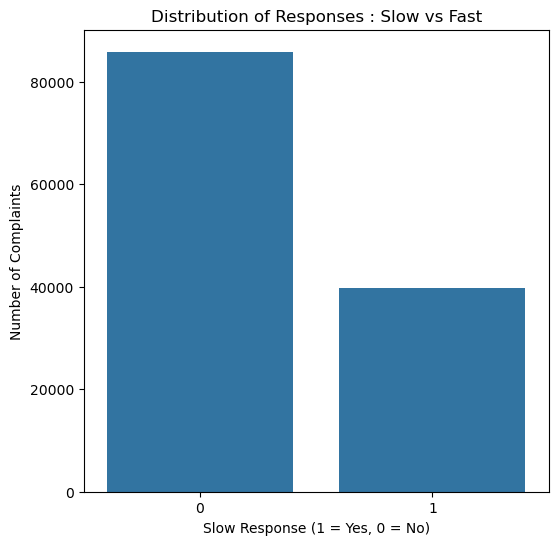

In [144]:
plt.figure(figsize=(6,6))
sns.countplot(x='Slow Response', data= service_requests)
plt.title('Distribution of Responses : Slow vs Fast')
plt.xlabel('Slow Response (1 = Yes, 0 = No)')
plt.ylabel('Number of Complaints')
plt.show()

## One Hot Encoding

In [147]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_encoded = encoder.fit_transform(features)
X_feature_names = encoder.get_feature_names_out(features.columns)
X = pd.DataFrame(X_encoded, columns=X_feature_names)

## Scale Features

In [150]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

## Train Test Split

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

## Train Model

In [156]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

## Evaluate Model

In [159]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     17198
           1       0.82      0.82      0.82      7896

    accuracy                           0.89     25094
   macro avg       0.87      0.87      0.87     25094
weighted avg       0.89      0.89      0.89     25094

Confusion Matrix:
 [[15787  1411]
 [ 1391  6505]]
ROC AUC Score: 0.9539899022211413


The logistic regression model continued to perform strongly in classifying whether a 311 service request would receive a slow or fast response, showing improvements after data cleaning. It achieved an accuracy of 89% and an excellent ROC AUC score of 0.95, reflecting its strong ability to distinguish between fast and slow complaints. The model achieved a precision of 0.82 and a recall of 0.82 for slow responses, meaning it correctly identified the majority of delayed cases while keeping false alarms relatively low. The F1-score for slow responses was 0.82, demonstrating a strong balance between precision and recall. According to the confusion matrix, out of 7,896 actual slow complaints, the model correctly predicted 6,505 and misclassified 1,391 as fast. Similarly, it correctly identified 15,787 out of 17,198 fast complaints, misclassifying only 1,411. These results indicate that the model is a reliable tool for flagging service delays in NYC’s 311 system, offering valuable support for improving agency responsiveness and prioritizing high-risk complaint types.

In [171]:
print(service_requests['Slow Response'].value_counts())

Slow Response
0    85821
1    39649
Name: count, dtype: int64


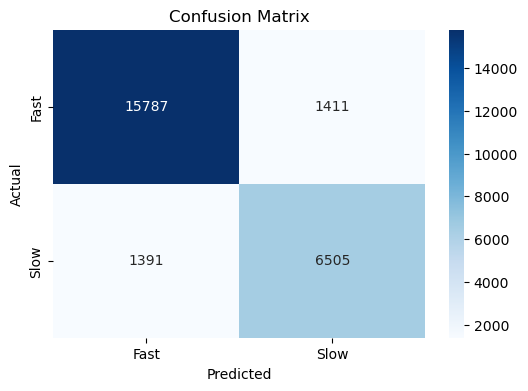

In [173]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fast', 'Slow'], yticklabels=['Fast', 'Slow'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

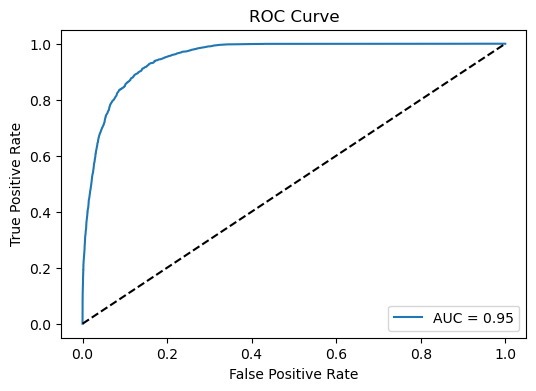

In [175]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

C:\Users\aasha\AppData\Local\Temp\ipykernel_17248\3239752318.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coefficients.head(15), x='Coefficient', y='Feature', palette='coolwarm')


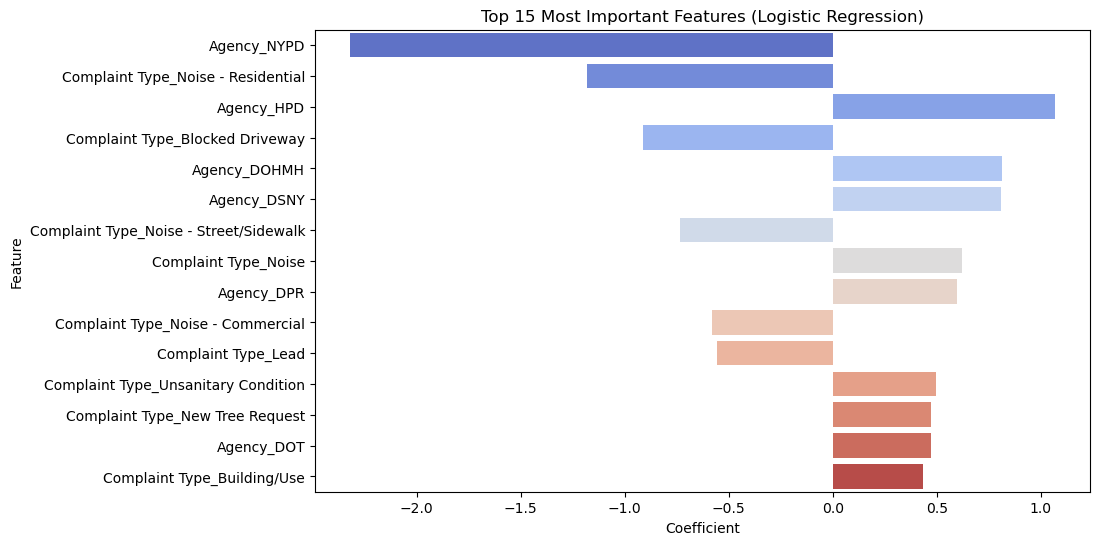

In [177]:
# Feature Importance
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=coefficients.head(15), x='Coefficient', y='Feature', palette='coolwarm')
plt.title('Top 15 Most Important Features (Logistic Regression)')
plt.show()

## Conclusion

This project successfully leveraged NYC 311 service request data to uncover patterns in complaint resolution times. After performing thorough data wrangling, exploratory analysis, and predictive modeling, several key insights emerged:

There are significant disparities in how quickly different types of 311 complaints are resolved.

Agencies such as NYPD and HPD are more likely to be associated with delayed responses.

Complaint types related to residential noise, heat/hot water issues, and health concerns tend to experience slower resolution times.

The logistic regression model achieved 89% accuracy and a ROC AUC of 0.95, demonstrating strong predictive power and reliability in identifying at-risk complaints.

These findings offer actionable insights that can help New York City improve its 311 operations by prioritizing high-delay complaints, addressing agency-level inefficiencies, and promoting a more equitable and timely public service experience for all residents.